# Zpětnovazební učení

V tomto cvičení budeme pracovat s Open AI gym, což je open source rozhraní určené pro úkoly zpětnovazebního učení. Jeho hlavní výhodou je, že implementace různých typů algoritmů pro zpětnovazební učení je v něm celkem jednoduchá. Popis základních funkcí Open AI gym se nachází v kódu níž.

Dnešní úkol bude naimplementovat agenta, který se učí chovat v nějakém prostředí (konkrétně v MountainCar) pomocí Q-učení.

Q-učení je způsob, kdy se agent učí svou strategii, jak se chovat v daném prostředí, pomocí zpětné vazby, kterou od prostředí za své chování dostává. Na rozdíl od hladového agenta, který jen v každém stavu vybírá nový stav na základě akce, co maximalizuje jeho užitek, bere v potaz to, že mezi stavy existují vztahy, které jsou dány Bellmanovými rovnicemi.

Nyní se tedy podíváme na příklad autíčka,které se snaží dostat do cíle, ale zatím se pohybuje náhodně.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

Ukážeme si, jak si vytvořit jednoduché prostředí *MountainCar*: https://gym.openai.com/envs/MountainCar-v0. 

Cílem je, aby se autíčko dostalo z údolí až nahoru k vlaječce, ale nemá dost silný motorek, takže se musí nejprve rozhoupat, aby tam vyjelo. V této základní verzi je zde v každém stavu náhodně zvolena akce pro pohyb.

In [2]:
env = gym.make('MountainCar-v0', render_mode='human')
observation, info = env.reset(seed=42)
for _ in range(100):
   action = env.action_space.sample()
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()
env.close()

Jen tak pro zajímavost existuje i například prostředí *CartPole*, kde je zase cílem vyvažovat tyčku, aby nespadla.

In [3]:
env = gym.make('CartPole-v0', render_mode='human')
observation, info = env.reset(seed=42)
for _ in range(100):
   action = env.action_space.sample()
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()
env.close()

C:\Users\katie\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\envs\registration.py:578: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


Opět si vytvoříme MountainCar prostředí. Můžeme si vypsat informace o rozměrech prostoru pozorování a akcí. 

In [4]:
env = gym.make('MountainCar-v0')

print('observation space:', env.observation_space)
print('observation space low:', env.observation_space.low)
print('observation space high:', env.observation_space.high)
print('action space:', env.action_space)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space low: [-1.2  -0.07]
observation space high: [0.6  0.07]
action space: Discrete(3)


Před spuštěním simulace prostředí je potřeba ho resetovat a dostaneme se do prvního pozorování, tedy počátečního stavu s počáteční náhodnou pozicí blízko minima údolí a nulovou rychlostí. Potom je potřeba v prostředí udělat nějakou akci. Třeba opět náhodnou, která se nám koneckonců bude za chvíli hodit pro náhodného agenta. Tu uděláme pomocí metody ```sample()```. Samotný krok, tedy vykonání akce v prostředí a posun do dalšího stavu, uděláme pomocí metody ```step(action)``` a získáme nové pozorování, o kterém si můžeme vypsat další užitečné informace jako odměnu, informaci o konci simulace a další info.  

In [5]:
observation = env.reset(seed=42)
print('initial observation:', observation)

action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)

print('next observation:', observation)
print('reward:', reward)
print('terminated:', terminated)
print('truncated:', truncated)
print('info:', info)
env.close()

initial observation: (array([-0.4452088,  0.       ], dtype=float32), {})
next observation: [-0.4457913  -0.00058252]
reward: -1.0
terminated: False
truncated: False
info: {}


Použijeme nyní kód výše a vytvoříme si do něj třídu pro agenta, který se v prostředí zatím bude chovat náhodně, což nám sice v tuto chvíli nepřinese nic užitečného, ale můžete ho později použít jako základ pro zpětnovazebního agenta.

Stav agenta dvojice je pozice a rychlost, akce může být pohyb vlevo, vpravo a nebo se nepohnout. Agent bude mít dvě metody, jednu na to, aby věděl, jak se má chovat a druhou aby se uměl resetovat. Agenta totiž budeme trénovat v několika iteracích. Pro zajímavost si také vypíšeme, jak vypadá prostředí, ve kterém se agent pohybuje.

In [6]:
# Obecna trida pro agenta
class RandomAgent:
    def __init__(self, actions):
        self.actions = actions
        self.train = True
    
    def act(self, observe, reward, done):
        return self.actions.sample()
    
    def reset(self):
        pass

Zkusíme si napsat trénovací cyklus. Každá iterace for cyklu je jedna hra s novým náhodným začátkem (kolem minima). Ve while cyklu se trénují přechody mezi stavy agenta. Zároveň si pamatujeme celkovou odměnu a číslo kroku (jeden krok je provedení jedné akce), které se nám bude hodit pro logování trénovacích cyklu. K tomu, aby se agent mohl něco učit musí získávat od prostředí nějakou odměnu. V tomto příkladu by měl agent dostávat v každém kroku odměnu -1, když není v cílovém stavu a 0 pokud v něm je. Snižující se suma odměn totiž agenta nutí, aby prohledával prostředí, a tedy vyjel nahoru co nejdříve.

In [7]:
agent = RandomAgent(env.action_space)
total_rewards = []
for i in range(1000):
    observation, info = env.reset()
    agent.reset()
    
    done = False
    terminated = False
    reward = 0
    total_reward = 0 # celkova odmena - jen pro logovani
    time = 0 # cislo kroku - jen pro logovani
    
    while not (done or terminated):
        action = agent.act(observation, reward, done or terminated)
        observation, reward, done, terminated, _ = env.step(action) 
        total_reward += reward
        time += 1
            
        
    total_rewards.append(total_reward)
    print(f"Iteration: {i}, reward: {total_reward}")
agent.train = False

Iteration: 0, reward: -200.0
Iteration: 1, reward: -200.0
Iteration: 2, reward: -200.0
Iteration: 3, reward: -200.0
Iteration: 4, reward: -200.0
Iteration: 5, reward: -200.0
Iteration: 6, reward: -200.0
Iteration: 7, reward: -200.0
Iteration: 8, reward: -200.0
Iteration: 9, reward: -200.0
Iteration: 10, reward: -200.0
Iteration: 11, reward: -200.0
Iteration: 12, reward: -200.0
Iteration: 13, reward: -200.0
Iteration: 14, reward: -200.0
Iteration: 15, reward: -200.0
Iteration: 16, reward: -200.0
Iteration: 17, reward: -200.0
Iteration: 18, reward: -200.0
Iteration: 19, reward: -200.0
Iteration: 20, reward: -200.0
Iteration: 21, reward: -200.0
Iteration: 22, reward: -200.0
Iteration: 23, reward: -200.0
Iteration: 24, reward: -200.0
Iteration: 25, reward: -200.0
Iteration: 26, reward: -200.0
Iteration: 27, reward: -200.0
Iteration: 28, reward: -200.0
Iteration: 29, reward: -200.0
Iteration: 30, reward: -200.0
Iteration: 31, reward: -200.0
Iteration: 32, reward: -200.0
Iteration: 33, rewar

Iteration: 286, reward: -200.0
Iteration: 287, reward: -200.0
Iteration: 288, reward: -200.0
Iteration: 289, reward: -200.0
Iteration: 290, reward: -200.0
Iteration: 291, reward: -200.0
Iteration: 292, reward: -200.0
Iteration: 293, reward: -200.0
Iteration: 294, reward: -200.0
Iteration: 295, reward: -200.0
Iteration: 296, reward: -200.0
Iteration: 297, reward: -200.0
Iteration: 298, reward: -200.0
Iteration: 299, reward: -200.0
Iteration: 300, reward: -200.0
Iteration: 301, reward: -200.0
Iteration: 302, reward: -200.0
Iteration: 303, reward: -200.0
Iteration: 304, reward: -200.0
Iteration: 305, reward: -200.0
Iteration: 306, reward: -200.0
Iteration: 307, reward: -200.0
Iteration: 308, reward: -200.0
Iteration: 309, reward: -200.0
Iteration: 310, reward: -200.0
Iteration: 311, reward: -200.0
Iteration: 312, reward: -200.0
Iteration: 313, reward: -200.0
Iteration: 314, reward: -200.0
Iteration: 315, reward: -200.0
Iteration: 316, reward: -200.0
Iteration: 317, reward: -200.0
Iteratio

Iteration: 559, reward: -200.0
Iteration: 560, reward: -200.0
Iteration: 561, reward: -200.0
Iteration: 562, reward: -200.0
Iteration: 563, reward: -200.0
Iteration: 564, reward: -200.0
Iteration: 565, reward: -200.0
Iteration: 566, reward: -200.0
Iteration: 567, reward: -200.0
Iteration: 568, reward: -200.0
Iteration: 569, reward: -200.0
Iteration: 570, reward: -200.0
Iteration: 571, reward: -200.0
Iteration: 572, reward: -200.0
Iteration: 573, reward: -200.0
Iteration: 574, reward: -200.0
Iteration: 575, reward: -200.0
Iteration: 576, reward: -200.0
Iteration: 577, reward: -200.0
Iteration: 578, reward: -200.0
Iteration: 579, reward: -200.0
Iteration: 580, reward: -200.0
Iteration: 581, reward: -200.0
Iteration: 582, reward: -200.0
Iteration: 583, reward: -200.0
Iteration: 584, reward: -200.0
Iteration: 585, reward: -200.0
Iteration: 586, reward: -200.0
Iteration: 587, reward: -200.0
Iteration: 588, reward: -200.0
Iteration: 589, reward: -200.0
Iteration: 590, reward: -200.0
Iteratio

Iteration: 846, reward: -200.0
Iteration: 847, reward: -200.0
Iteration: 848, reward: -200.0
Iteration: 849, reward: -200.0
Iteration: 850, reward: -200.0
Iteration: 851, reward: -200.0
Iteration: 852, reward: -200.0
Iteration: 853, reward: -200.0
Iteration: 854, reward: -200.0
Iteration: 855, reward: -200.0
Iteration: 856, reward: -200.0
Iteration: 857, reward: -200.0
Iteration: 858, reward: -200.0
Iteration: 859, reward: -200.0
Iteration: 860, reward: -200.0
Iteration: 861, reward: -200.0
Iteration: 862, reward: -200.0
Iteration: 863, reward: -200.0
Iteration: 864, reward: -200.0
Iteration: 865, reward: -200.0
Iteration: 866, reward: -200.0
Iteration: 867, reward: -200.0
Iteration: 868, reward: -200.0
Iteration: 869, reward: -200.0
Iteration: 870, reward: -200.0
Iteration: 871, reward: -200.0
Iteration: 872, reward: -200.0
Iteration: 873, reward: -200.0
Iteration: 874, reward: -200.0
Iteration: 875, reward: -200.0
Iteration: 876, reward: -200.0
Iteration: 877, reward: -200.0
Iteratio

Na konec si zobrazíme animaci a graf učení, abychom viděli, jak se náš agent učil. K tomu budeme potřebovat pomocnou funkci ```show_animation```, která umí zobrazit chování agenta v daném prostředí. Jako parametry má vizualizovaného agenta s implementouvanou metodou ```act```, open AI přístředí, které se má použít, počet simulovaných kroků v epizodě a počet epizod.

In [8]:
def show_animation(agent, env, steps=200, episodes=1):
    for i in range(episodes):
        observation = env.reset()
        done = False
        terminated = False
        total_reward = 0
        time = 0
        reward = 0
        while not (done or terminated) and time < steps:
            env.render()
            action = agent.act(observation, reward, done)
            observation, reward, done, terminated, _  = env.step(action)
            total_reward += reward
            time += 1
        agent.reset()

def moving_average(x, n):
    weights = np.ones(n)/n
    return np.convolve(np.asarray(x), weights, mode='valid')

Z výsledků vidíme, že se agent moc neučil, což dává smysl, protože nemá implementované žádné rozumné učící se tělo (akce se vybírají náhodně).

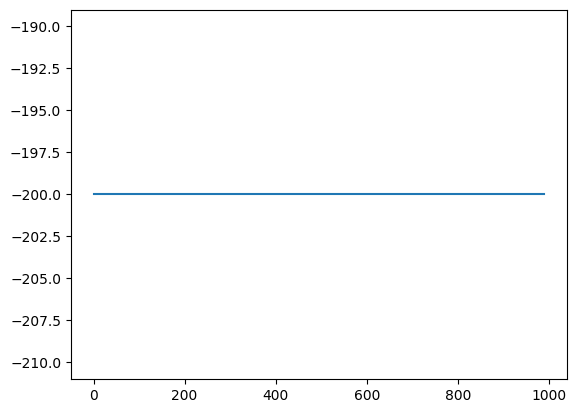

In [9]:
env = gym.make('MountainCar-v0', render_mode='human')
show_animation(agent, env, steps=1000, episodes=5)
plt.plot(moving_average(total_rewards, 10))
plt.show() 

env.close()

## Úkol na cvičení

Zkuste si místo náhodného agenta naprogramovat třídu agenta pomocí Q-učení, který se učí chovat v prostředí MountainCar. Dejte pozor na to, že prostředí vrací jako stav spojité hodnoty (poloha i rychlost jsou obě spojité), takže je třeba si z nich nějak udělat prostředí diskrétní (tedy s konečným množstvím stavů). Čím menší budou diskretizované intervaly, tím bude učení přesnější, ale tím déle bude trvat, takže je potřeba najít nějakou rozumnou hranici (ideálně vyzkoušením více hodnot). Dále můžete také experimentovat s dalšími parametry, například měnit maximální počty kroků, případně hodnotu odměny a pozorovat, jak se bude učení měnit.

Při implementaci můžete vycházet z následujícího interface (ale nemusíte).

In [10]:
class StateDiscretizer:
  # predani rozmeru prostredi a spojitych stavu a jejich rozdeleni na diskretni intervaly
    def __init__(self, ranges, states):
        pass
    
    # prirazeni stavu do spravneho intervalu
    def transform(self, obs):
        pass
        
class QLearningAgent:
    # nastaveni moznych akci - L, N, R   
    # diskretizace stavu prostredi
    # definice matice uzitku Q[stavy, akce]
    # promenna na zapamatovani si minuleho stavu a minule akce
    # donastaveni dalsich parametru trenovani
    def __init__(self, actions, state_transformer, train=True):
        pass
    
    # na zaklade stavu a akce se vybira nova akce
    # 1. najde se nejlepsi akce pro dany stav
    # 2. s malou pravd. vezme nahodnou
    # 3. updatuje se Q matice
    def act(self, observe, reward, done):
        pass

    # reset minuleho stavu a akce na konci epizody
    def reset(self):
        pass